Most of today will be working with RNNs or LSTMs, but we can also use CNNs or Convolutional Neural Networks with text as well. One of the more well known models comes from "Text Understanding from Scratch" by Zhang, LeCun 2015 https://arxiv.org/pdf/1502.01710v4.pdf this model is a series of 1D CNNs, with a maxpooling and fully connected layers.

The idea behind the model is that earlier convolutions determine low level features in the text, which then feed into the later convolutions. This is similar to how a CNN in computer vision will learn how to clasify objects. One of my favorite visualizations of this comes from https://www.cc.gatech.edu/~hays/compvision2017/proj6/. 

![alt text](deepNetVis.png)

At its core a convolution is the multiplication of two matrices - one of which is the input cells, and the other is the convolutional cell. The image below from https://medium.freecodecamp.org/an-intuitive-guide-to-convolutional-neural-networks-260c2de0a050 shows the output of a 3x3 convolutional matrix (the green matrix) over some input (blue). The convolutional matrix will scan across the entire input to fill out the ouput (the red matrix).

![alt text](convolution.png)

The "Text Understanding from Scratch" is a series of 6 convolutional layers followed by three fully connected layers. 

![alt text](textUnderstand.png)

For this section of the demo we are going to briefly step away from PyTorch and use Keras. Keras uses static graphs which means that we have to fix the length of text documents and are not able to as easily probe intermediary layers of the model. However, it is a higher level deep learning language so we can focus more on the data setup and how the algorithm is performing as opposed to how to write the code. This demo comes from the NLP Architect repo at https://github.com/NervanaSystems/nlp-architect 

The first step we need to take is to format our text so that it is in a one-hot encoding. The advantages of this type of encoding is that we don't have to create a vocabulary (which means there is no out of vocab issues), and it can work for any language. We are going to work with the same dataset as in the Lifecycle tutorial - the 20 Newsgroups dataset.

In [1]:
# Import packages
from sklearn.datasets import fetch_20newsgroups
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
import re
import numpy as np

from keras.optimizers import RMSprop, SGD
from keras.models import Sequential, Model
from keras.layers.core import Dense, Dropout, Activation, Flatten, Reshape
from keras.layers.convolutional import Conv1D, MaxPooling1D

%matplotlib inline

import matplotlib.pyplot as plt
from matplotlib import pyplot

Using TensorFlow backend.


In [2]:
from sklearn.datasets import fetch_20newsgroups

categories = [
    'rec.autos',
    'rec.motorcycles',
    'sci.space'
]

# Again we remove the headers, footers and quotes only keeps the line information
# The header and footer information in particular have metadata which would cause the algorithm to be overfitted
newsgroups_train = fetch_20newsgroups(subset='train', categories=categories, random_state=42, remove=('headers', 'footers', 'quotes'))
newsgroups_test = fetch_20newsgroups(subset='test', categories=categories, random_state=42, remove=('headers', 'footers', 'quotes'))
dense_out=len(newsgroups_train.target_names) #length of features

In [3]:
max_len = 300
zhang_lecun_vocab=list("abcdefghijklmnopqrstuvwxyz0123456789-,;.!?:’’’/\|_@#$%ˆ&*˜‘+-=<>()[]{}") 
vocab_hash = {b: a for a, b in enumerate(zhang_lecun_vocab)}

def to_one_hot(txt, length = max_len, vocab=vocab_hash):
    
    vocab_size = len(vocab.keys())
    one_hot_vec = np.zeros((vocab_size, length), dtype=np.float32)
    # run through txt and "switch on" relevant positions in one-hot vector
    for idx, char in enumerate(txt):
        try:
            vocab_idx = vocab_hash[char.lower()]
            one_hot_vec[vocab_idx, idx] = 1
        # raised if character is out of vocabulary
        except:
            #print(char)
            pass
    return one_hot_vec

def on_hot_label(label_val, num_labels):
    one_hot_vec = np.zeros(num_labels)
    one_hot_vec[label_val]=1
    return one_hot_vec

In [4]:
to_one_hot("a Cat ate foccacia!")

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [5]:
on_hot_label(2,dense_out)

array([0., 0., 1.])

Now that we understand the one_hot encoding better we can process our data.
Note that we aren't doing any cleaning except for making everything lowercase

In [6]:
X_train_a_ = [to_one_hot(x) for x in newsgroups_train.data]
X_test_a_ = [to_one_hot(x) for x in newsgroups_test.data]

X_train_a = np.asarray(X_train_a_)
Y_train_a = np.asarray([on_hot_label(l, dense_out) for l in newsgroups_train.target])

X_test_a = np.asarray(X_test_a_)
Y_test_a = np.asarray([on_hot_label(l, dense_out) for l in newsgroups_test.target])

print(X_train_a.shape)
print(Y_train_a.shape)

(1785, 67, 300)
(1785, 3)


In [7]:
def one_hot_cnn(dense_out, max_len=max_len, frame='small'):

    if frame == 'large':
        cnn_size = 1024
        fully_connected = [2048,2048,dense_out]
    elif frame =='small':
        cnn_size = 256
        fully_connected = [1024,1024,dense_out]
    elif frame =='tiny':
        cnn_size = 128
        fully_connected = [512,512,dense_out]
        

    model = Sequential()

    model.add(Conv1D(cnn_size, 7, padding='same', input_shape=(67, max_len)))
    model.add(MaxPooling1D(pool_size=3))

    #Input = 22 x cnn_size
    model.add(Conv1D(cnn_size, 7, padding='same'))
    model.add(MaxPooling1D(pool_size=3))

    #Input = 7 x cnn_size
    model.add(Conv1D(cnn_size,3, padding='same'))

    #Input = 7 x cnn_size
    model.add(Conv1D(cnn_size,3, padding='same'))

    model.add(Conv1D(cnn_size,3, padding='same'))

    # #Input = 7 x cnn_size
    model.add(Conv1D(cnn_size, 3, padding='same'))
    model.add(MaxPooling1D(pool_size=3))
    
    model.add(Flatten())

    #Fully Connected Layers

    #Input is 512 Output is 1024/2048
    model.add(Dense(fully_connected[0]))
    model.add(Dropout(0.75))
    model.add(Activation('relu'))

    #Input is 1024/2048 Output is 1024/2048
    model.add(Dense(fully_connected[1]))
    model.add(Dropout(0.75))
    model.add(Activation('relu'))

    #Input is 1024/2048 Output is dense_out size (number of classes)
    model.add(Dense(fully_connected[2]))
    model.add(Activation('softmax'))

    #Stochastic gradient parameters as set by paper
    sgd = SGD(lr=0.01, decay=1e-5, momentum=0.9, nesterov=True)
    model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

    return model

In [8]:
dense_out=len(newsgroups_train.target_names) #length of features

model_cnn = one_hot_cnn(dense_out, frame='small')
model_cnn.summary()

Instructions for updating:
`NHWC` for data_format is deprecated, use `NWC` instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 67, 256)           537856    
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 22, 256)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 22, 256)           459008    
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 7, 256)            0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 7,

In [9]:
model_hist_cnn = model_cnn.fit(X_train_a, Y_train_a, batch_size=64, epochs=20, verbose=1, 
          validation_data=(X_test_a,Y_test_a))

Train on 1785 samples, validate on 1188 samples
Epoch 1/20
1785/1785 [==============================] - 5s 3ms/step - loss: 1.1285 - acc: 0.3221 - val_loss: 1.0982 - val_acc: 0.3460
Epoch 2/20
1785/1785 [==============================] - 5s 3ms/step - loss: 1.1108 - acc: 0.3501 - val_loss: 1.1006 - val_acc: 0.3350
Epoch 3/20
1785/1785 [==============================] - 5s 3ms/step - loss: 1.1081 - acc: 0.3457 - val_loss: 1.0946 - val_acc: 0.3889
Epoch 4/20
1785/1785 [==============================] - 5s 3ms/step - loss: 1.1096 - acc: 0.3485 - val_loss: 1.0946 - val_acc: 0.3502
Epoch 5/20
1785/1785 [==============================] - 5s 3ms/step - loss: 1.0985 - acc: 0.3754 - val_loss: 1.0928 - val_acc: 0.4040
Epoch 6/20
1785/1785 [==============================] - 5s 3ms/step - loss: 1.0911 - acc: 0.3838 - val_loss: 1.0928 - val_acc: 0.3485
Epoch 7/20
1785/1785 [==============================] - 5s 3ms/step - loss: 1.0790 - acc: 0.4000 - val_loss: 1.0900 - val_acc: 0.3704
Epoch 8/20
178

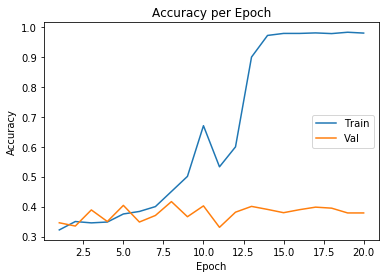

In [10]:
# Training Accuracy
x = np.arange(20)+1

plt.plot(x, model_hist_cnn.history['acc'])
plt.plot(x, model_hist_cnn.history['val_acc'])
plt.legend(['Train', 'Val'], loc='right')
plt.ylabel("Accuracy")
axes = plt.gca()
plt.xlabel("Epoch")
plt.title("Accuracy per Epoch")
plt.show()

## Try it with your own text

Like we did in the last exercise lets try it out with our own text and see how the result varies.

In [11]:
text_input = "I always loved watching the stars, and whenever I have the change I watch for satellites overhead :)"

In [21]:
one_hot_input = np.asarray([to_one_hot(text_input)])
input_prediction = model_cnn.predict(one_hot_input)

print("This text most fits in %s with a probability of %f" 
      %(newsgroups_train.target_names[np.argmax(input_prediction[0])],max(input_prediction[0])))

This text most fits in rec.motorcycles with a probability of 0.997340
